In [2]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
#import seaborn as sb  
from scipy.io import loadmat  

#将matplotlib图像内嵌入jupyter中，当输入plt.plot(x,y_1)后，不必再输入 plt.show()，图像将自动显示出来
%matplotlib inline   

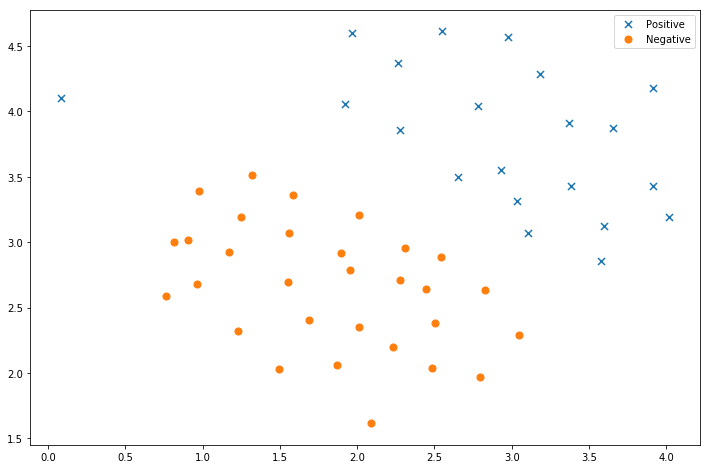

In [3]:
#看第一个文件，这是一个soft-margin 线性集
raw_data = loadmat('ex6data1.mat')  
data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])   #存入dataframe中
data['y'] = raw_data['y']
positive=data[data['y'].isin([1])]
negative=data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
#注意，fig,ax = plt.subplots()等价于：
#1/ fig = plt.figure()
#2/ ax = fig.add_subplot(1,1,1)
#fig, ax = plt.subplots(1,3,1),最后一个参数1代表第一个子图。
#fig, ax = plt.subplots(1,3,figsize=(15,7))，这样就会有1行3个15x7大小的子图。
ax.scatter(positive['X1'], positive['X2'], s=50, marker='x', label='Positive')  
ax.scatter(negative['X1'], negative['X2'], s=50, marker='o', label='Negative') 
ax.legend() 

In [4]:
#使用sklearn内置的SVM，构建线性SVM模型
from sklearn import svm  
svc = svm.LinearSVC(C=1,loss='hinge',max_iter=1000)  #loss='hinge'指定损失函数：“hinge”是标准的SVM损失（例如由SVC类使用），而“squared_hinge”（自动）是hinge损失的平方。
#训练模型svc
svc.fit(data[['X1', 'X2']], data['y'])  
svc.score(data[['X1', 'X2']], data['y'])  
#发现得分0.98，则是图中左上方的离群点被错误分类

D:\anaconda\envs\py37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9803921568627451

In [62]:
#增加惩罚系数C,可以得到score：1.0，但是我发现不是每次都是1.0，有时候甚至只有0.94，要反复尝试
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=1000)  
svc2.fit(data[['X1', 'X2']], data['y'])  
svc2.score(data[['X1', 'X2']], data['y'])  
#这次我们得到了训练数据的完美分类，然而通过增加 C 的值，我们创建的一个决策边界不再是数据的自然拟合,即已经过拟合。 
#可以通过查看每个类预测的置信水平来可视化这些，置信水平是点到超平面的距离的函数。

D:\anaconda\envs\py37\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1.0

Text(0.5, 1.0, 'SVM (C=1) Decision Confidence')

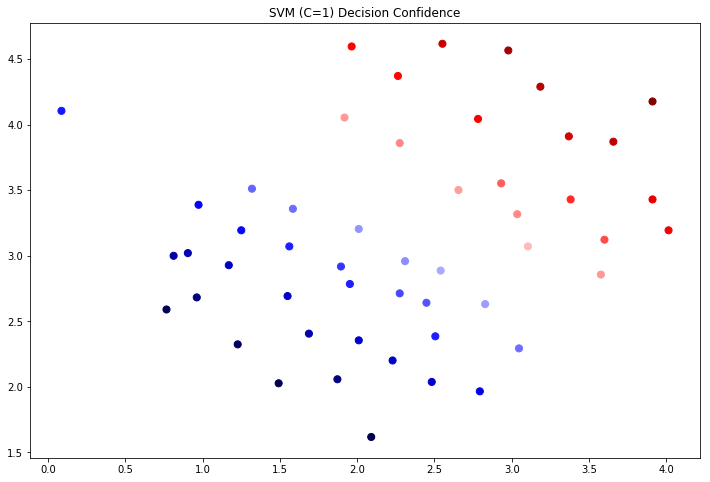

In [6]:
data['SVM 1 Confidence'] = svc.decision_function(data[['X1', 'X2']])      #decision_function计算的是置信水平，即点到超平面的距离
                                                                          #在正常分类的一般情况下，每个点的置信水平与y同号
fig, ax = plt.subplots(figsize=(12,8)) 
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 1 Confidence'], cmap='seismic') #注意这个cmap='seismic'很重要，看看去掉是什么样子
ax.set_title('SVM (C=1) Decision Confidence') 

Text(0.5, 1.0, 'SVM (C=100) Decision Confidence')

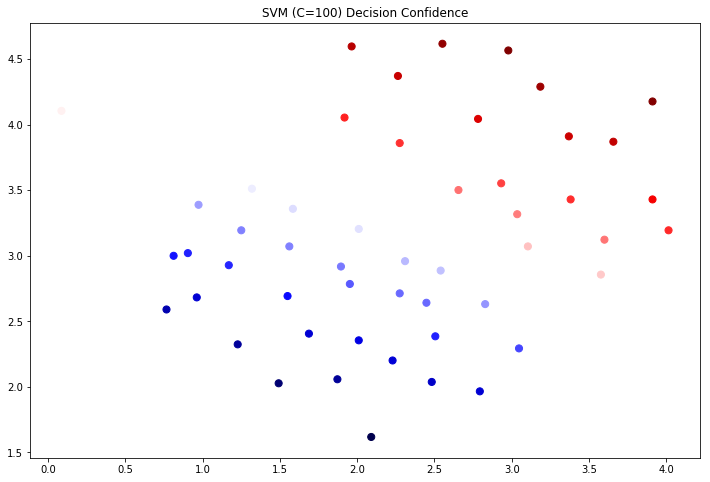

In [80]:
data['SVM 2 Confidence'] = svc2.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 2 Confidence'], cmap='seismic')  
ax.set_title('SVM (C=100) Decision Confidence')  
#颜色越浅，越代表支持向量的属性，因此这里C变大之后，左上方的点也变成了支持向量，也被正确分类并较大程度影响着分类面

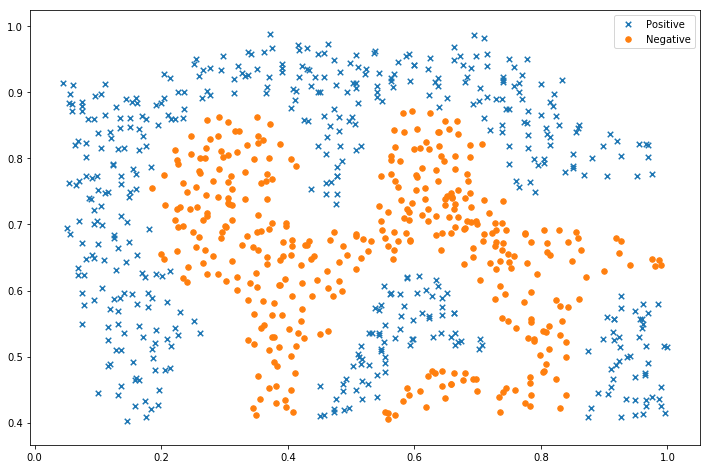

In [84]:
#现在我们将从线性SVM（linearSVC） 转移到能使用核（kernel）进行非线性分类的 SVM（SVC）。
#我们来看第二个data文件,这是非线性的
raw_data = loadmat('ex6data2.mat')

data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])  
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]  
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['X1'], positive['X2'], s=30, marker='x', label='Positive')  
ax.scatter(negative['X1'], negative['X2'], s=30, marker='o', label='Negative')  
ax.legend()  

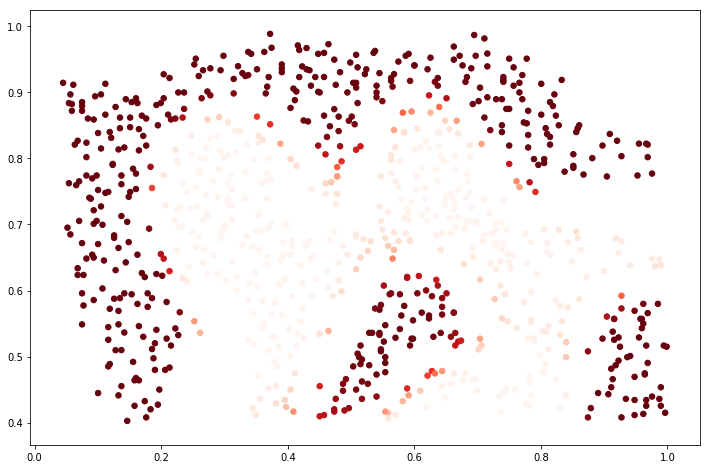

In [91]:
#使用内置的SVC
svc = svm.SVC(C=100, gamma=10, probability=True)  #gamma对应台大的系数
svc.fit(data[['X1', 'X2']], data['y'])  
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,1]  #predict_proba返回的是一个n行k列的数组，
    #第i行第j列上的数值是模型预测第i个预测样本的标签为j的概率。因此svc.predict_proba(data[['X1', 'X2']])的shape为863*2
fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(data['X1'], data['X2'], s=30, c=data['Probability'],cmap='Reds')      #预测标签为positive的概率，发现大多数点被正确分类

In [108]:
#我们来看第二个data文件,包含了训练集和验证集，并且任务是基于验证集的表现为 SVM 模型找到最佳超参数。
#虽然我们使用 scikit-learn 的内置网格搜索做到这一点很容易，但本着遵循练习的指导的精神，我们将从头开始实现一个简单的网格搜索。
raw_data = loadmat('ex6data3.mat')

X = raw_data['X']  
Xval = raw_data['Xval']  
y = raw_data['y'].ravel()   #.ravel是对数组展开,y的shape由(n,1)变成了(n,)
yval = raw_data['yval'].ravel()
C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]  
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

best_score = 0  
best_params = {'C': None, 'gamma': None}

for C in C_values:  
    for gamma in gamma_values:
        svc = svm.SVC(C=C, gamma=gamma)
        svc.fit(X, y)
        score = svc.score(Xval, yval)

        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

best_score, best_params  

(0.965, {'C': 0.3, 'gamma': 100})